In [1]:
RAW_DIR = r"D:\Project\Leaf Class raw" # <-- change if needed
PROCESSED_DIR = r"D:\Project\Leaf Class\processed_all" # preprocessed + augmented saved here
DATASET_DIR = r"D:\Project\Leaf Class\dataset" # final train/val/test


IMAGE_SIZE = (224, 224) # model input size
TARGET_PER_CLASS = 600 # desired total images per class after augmentation (set None or <=0 to skip augmentation)


TRAIN_RATIO = 0.60
VAL_RATIO = 0.20
TEST_RATIO = 0.20



RANDOM_SEED = 42

In [2]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [3]:
import sys
print(sys.executable)

d:\Project\Project code\.venv\Scripts\python.exe


In [5]:
import os
import shutil
import random
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [6]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


# helper function
def is_image_file(fn):
    fn = fn.lower()
    return fn.endswith('.jpg') or fn.endswith('.jpeg') or fn.endswith('.png')



# make sure dirs exist
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)


# find classes in RAW_DIR
classes = [d for d in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, d))]
classes.sort()
print(f"Found {len(classes)} classes: {classes}")

Found 12 classes: ['Artocarpus heterophyllus', 'Bambusa vulgaris', 'Coccinia grandis', 'Codiaeum variegatum', 'Ficus benghalensis', 'Foliorum Forma - Orbicularis', 'Herbarium Oxalis', 'Hevea brasiliensis', 'Indonesian Bay', 'Lembu', 'Mangifera indica', 'Psidium guajava']


In [7]:
import cv2
print(cv2.__version__)

4.12.0


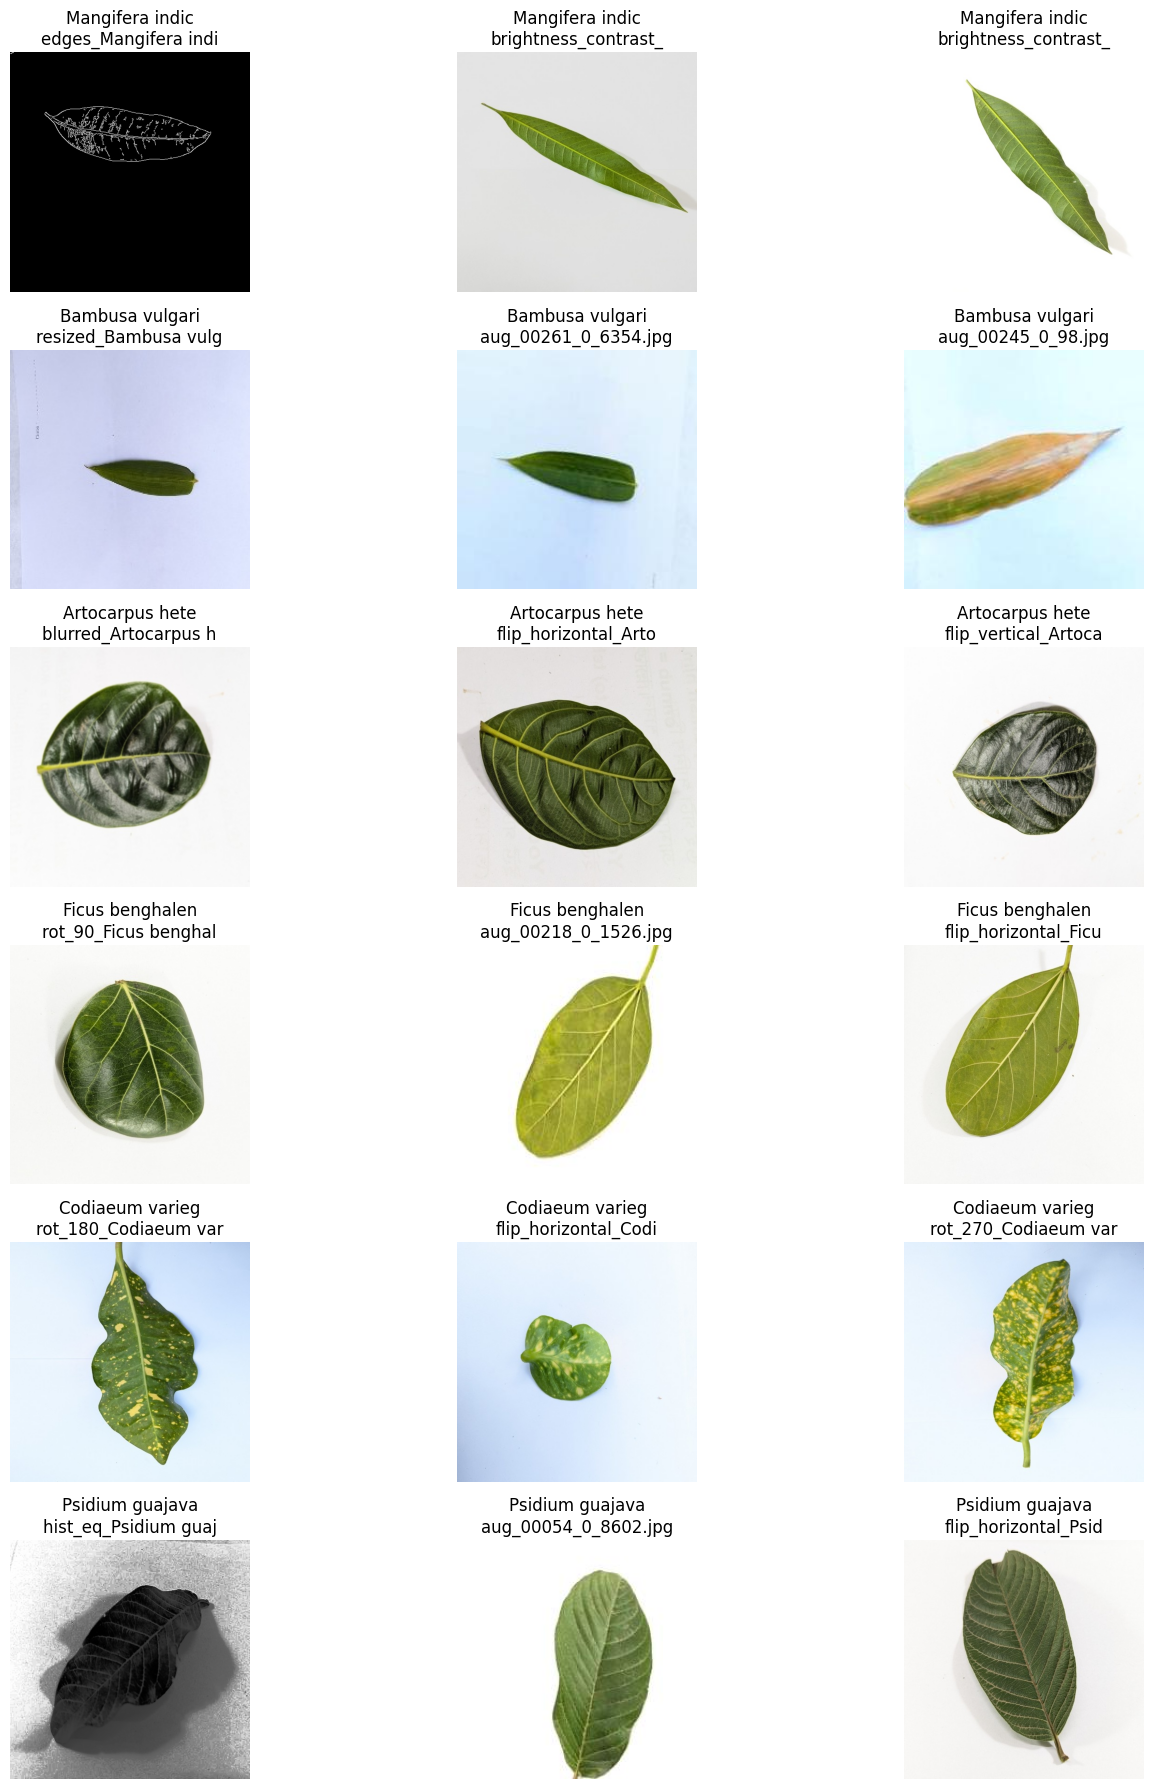

In [8]:
import matplotlib.pyplot as plt
import cv2, os, random
import math

SAMPLE_PER_CLASS = 3  # how many per class
NUM_CLASSES_TO_SHOW = min(6, len(classes))  # adjust how many classes to display

selected_classes = random.sample(classes, NUM_CLASSES_TO_SHOW)
total_images = NUM_CLASSES_TO_SHOW * SAMPLE_PER_CLASS

# Calculate grid size
cols = SAMPLE_PER_CLASS
rows = math.ceil(total_images / cols)

plt.figure(figsize=(15, 3 * rows))  # adjust height based on rows
i = 1

for class_name in selected_classes:
    class_folder = os.path.join(PROCESSED_DIR, class_name)
    images = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png'))]

    for img_name in random.sample(images, min(SAMPLE_PER_CLASS, len(images))):
        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip unreadable images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(f"{class_name[:15]}\n{img_name[:20]}")
        plt.axis("off")
        i += 1

plt.tight_layout()
plt.show()

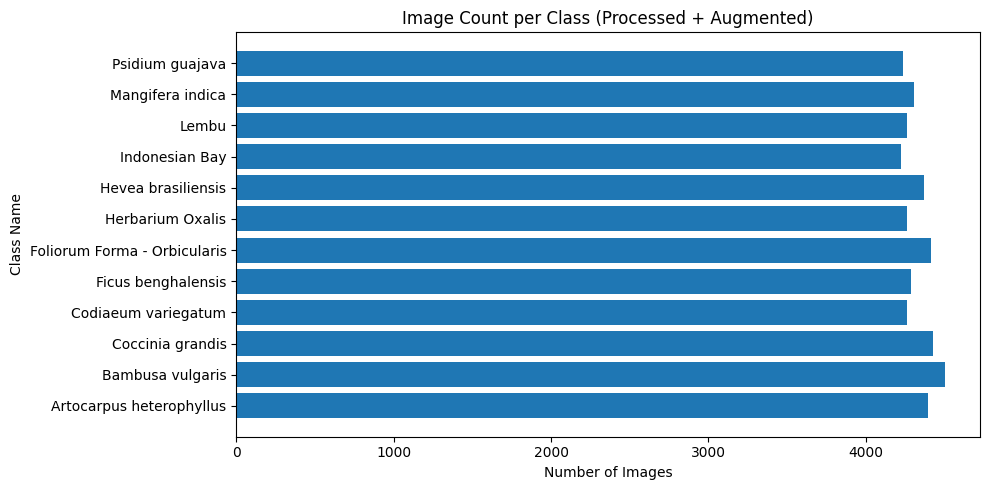

In [9]:
import matplotlib.pyplot as plt

class_counts = {}

for cls in classes:
    class_dir = os.path.join(PROCESSED_DIR, cls)
    class_counts[cls] = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))])

plt.figure(figsize=(10,5))
plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.title("Image Count per Class (Processed + Augmented)")
plt.xlabel("Number of Images")
plt.ylabel("Class Name")
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras import models, layers

base_dir = r"D:\Project\Leaf Class\dataset"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 31157 images belonging to 12 classes.
Found 10383 images belonging to 12 classes.
Found 10396 images belonging to 12 classes.


In [11]:
num_classes = len(train_data.class_indices)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

d:\Project\Project code\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,508 (42.61 MB)

 Trainable params: 11,170,508 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers

# Set a random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Paths to your dataset
TRAIN_DIR = r"D:\Project\Leaf Class\dataset\train"
VAL_DIR = r"D:\Project\Leaf Class\dataset\val"

# Image size
img_size = (224, 224)

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=img_size,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=img_size,
    class_mode='categorical',
    shuffle=False
)

# Get number of classes
num_classes = len(train_data.class_indices)

# Build the CNN model (as per your original code)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(
    train_data,
    epochs=25,
    validation_data=val_data
)


Found 31157 images belonging to 12 classes.
Found 10383 images belonging to 12 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,508 (42.61 MB)

 Trainable params: 11,170,508 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

d:\Project\Project code\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 1172s 1s/step - accuracy: 0.4940 - loss: 1.4327 - val_accuracy: 0.7336 - val_loss: 0.7811
Epoch 2/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 424s 435ms/step - accuracy: 0.7116 - loss: 0.8261 - val_accuracy: 0.7858 - val_loss: 0.6632
Epoch 3/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 436s 448ms/step - accuracy: 0.8078 - loss: 0.5539 - val_accuracy: 0.9000 - val_loss: 0.3076
Epoch 4/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 437s 449ms/step - accuracy: 0.8639 - loss: 0.4060 - val_accuracy: 0.9193 - val_loss: 0.2542
Epoch 5/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 429s 440ms/step - accuracy: 0.8906 - loss: 0.3206 - val_accuracy: 0.9217 - val_loss: 0.2426
Epoch 6/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 422s 433ms/step - accuracy: 0.9136 - loss: 0.2511 - val_accuracy: 0.9274 - val_loss: 0.2224
Epoch 7/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 415s 426ms/step - accuracy: 0.9216 - loss: 0.2289 - val_accuracy: 0.9256 - val_loss: 0.2478
Epoch 8/25
974/974 ━━━━━━━━━━━━━━━━━━━━ 410s 421ms/step - accuracy: 0.9393 - l

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
model.save("D:/Project/Leaf_Model/leaf_classifier_model_CNN1610.h5")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Get the true labels
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

# Predict
pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)

In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix with Class Labels')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:")
print(report)

In [ ]:
#new model


In [ ]:
from tensorflow.keras import models, layers

base_dir = r"D:\Project\Leaf Class\dataset"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


In [ ]:
num_classes = len(train_data.class_indices)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
num_classes = len(train_data.class_indices)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
num_classes = len(train_data.class_indices)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
model.save("D:/Project/Leaf_Model/leaf_classifier_model_CNN1610.h5")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Get the true labels
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

# Predict
pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)

In [ ]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix with Class Labels')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:")
print(report)